In [1]:
import collections
import itertools
import time

import networkx as nx
import numpy as np
import pandas as pd
import sonnet as snt
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from graph_nets import graphs, modules, utils_np, utils_tf

In [8]:
seed = 4321
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set()

In [9]:
## util functions for creating batched graph data

def random_graph(num_nodes, p=0.5):
    """
    Creates one random graph using the GNP algorithm, which gives at
    most a complete graph with num_nodes and p probability of edge
    connectivity. Assigns random edge lengths drawn from a standard
    lognormal.

    Args:
        num_nodes: number of nodes in the graph
        p: probability of creating an edge between any two nodes

    Returns:
        A random networkx graph generated with the GNP algorithm
    """

    # create a graph object and add nodes
    g = nx.Graph()
    g.add_nodes_from(range(num_nodes))

    # for each node, add the degree as a node feature
    node_degrees = nx.degree(g)
    for node in g.nodes():
        g.nodes[node]['features'] = [float(node_degrees[node])]


    # add edges with probability p
    # make sure there's at least one edge
    node_pairs = list(itertools.combinations(g.nodes, 2))
    edges = [e for e in node_pairs if np.random.uniform() > p]
    if len(edges) == 0:
        edges = [node_pairs[np.random.choice(len(node_pairs))]]
    g.add_edges_from(edges)

    # for each edge, assign a random length
    total_length = 0
    for edge in g.edges():
        edge_length = np.random.lognormal()
        g.get_edge_data(*edge)['features'] = [edge_length]
        g.get_edge_data(*edge)['weight'] = edge_length
        total_length += edge_length


    # add global features to the graph (casting to avoid np/tf type conversion issues)
    g.graph['features'] = [
        float(len(g.nodes)),
        float(len(g.edges())),
        float(float(total_length))
    ]

    return g


def min_span_tree_length(graph):
    """
    Computes the total edge length of the minimum spanning tree of the
    input graph.

    Args:
        graph: a networkx Graph object

    Returns:
        min spanning tree length
    """

    # get the edge set of the min spanning tree using the built-in nx function
    min_span_edges = nx.minimum_spanning_edges(graph, weight='weight')

    # compute the total length
    total_edge_length = sum([e[2]['weight'] for e in min_span_edges])

    return total_edge_length


def create_graphs(num_graphs, min_num_nodes=2, max_num_nodes=20):
    """
    Creates a list of random networkx graphs with a bounded number of nodes and at
    most a complete graph. Then computes the total edge length of the minimum
    spanning tree for each graph (this will be the training target).

    Args:
        num_graphs: number of graphs to generate (e.g. batch size)
        min_num_nodes: minimum number of nodes in any graph
        max_num_nodes: maximum number of nodes in any graph

    Returns:
        graphs: a list of the random graphs
        targets: a list of the training targets
    """

    # generate random parameter args for the graphs
    n_nodes = np.random.randint(min_num_nodes, max_num_nodes+1, size=num_graphs)
    edge_p = np.random.uniform(low=0.2, size=num_graphs)
    graph_params = list(zip(n_nodes, edge_p))

    # generate a list of networkx graphs
    graphs = [random_graph(*params) for params in graph_params]

    # compute the target for each graph
    targets = [min_span_tree_length(g) for g in graphs]

    return graphs, targets

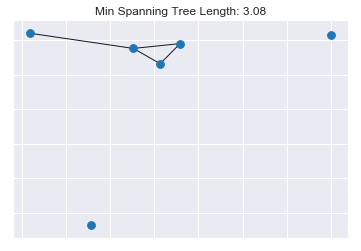

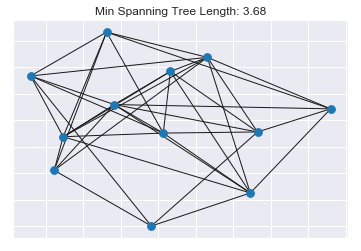

In [10]:
# test the graph generator functions
graphs, targets = create_graphs(2, min_num_nodes=4, max_num_nodes=15)

# draw the graphs
def draw_graph(graph, target):
    plt.figure()
    pos = nx.spring_layout(graph)
    nx.draw_networkx(graph, pos, node_size=60, with_labels=False)
    plt.title('Min Spanning Tree Length: {:.2f}'.format(target))

[draw_graph(*pair) for pair in list(zip(graphs, targets))];

In [11]:
# this block contains classes for creating a GraphNet model and is
# a slightly modified version of DeepMind's example message-passing 
# encode-process-decode model found here:
#      https://github.com/deepmind/graph_nets/blob/master/graph_nets/demos_tf2/models.py

def make_mlp_model(layer_shape=[24, 24]):
    """
    Generates a new MLP + LayerNorm module

    Args:
        layer_shape: a list of length n_layers, where elements are the number of nodes

    Returns:
        A Sonnet module containing an MLP + LayerNorm
    """

    return snt.Sequential([
        snt.nets.MLP(layer_shape, activate_final=True),
        snt.LayerNorm(axis=-1, create_offset=True, create_scale=True)
    ])


class EncodeProcessDecode(snt.Module):
    """
    The full encode-process-decode module from the graph-nets paper.

                        Hidden(t)   Hidden(t+1)
                           |            ^
              *---------*  |  *------*  |  *---------*
              |         |  |  |      |  |  |         |
    Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
              |         |---->|      |     |         |
              *---------*     *------*     *---------*
    """

    def __init__(self,
                 num_processing_steps=1,
                 edge_output_size=None,
                 node_output_size=None,
                 global_output_size=None,
                 name="EncodeProcessDecode"):
        super(EncodeProcessDecode, self).__init__(name=name)

        # this is the number of message-passing steps
        self._num_processing_steps = num_processing_steps

        self._encoder = modules.GraphIndependent(make_mlp_model, make_mlp_model, make_mlp_model)
        self._core = modules.GraphIndependent(make_mlp_model, make_mlp_model, make_mlp_model)
        self._decoder = modules.GraphIndependent(make_mlp_model, make_mlp_model, make_mlp_model)

        # the final layer is an output transformation (e.g. for classification, output size
        # should be 1)
        if edge_output_size is None:
            edge_fn = None
        else:
            edge_fn = lambda: snt.Linear(edge_output_size, name="edge_output")

        if node_output_size is None:
            node_fn = None
        else:
            node_fn = lambda: snt.Linear(node_output_size, name="node_output")

        if global_output_size is None:
            global_fn = None
        else:
            global_fn = lambda: snt.Linear(global_output_size, name="global_output")

        self._output_transform =modules.GraphIndependent(edge_fn, node_fn, global_fn)

    def __call__(self, inputs):
        latent = self._encoder(inputs)

        latent0 = latent
        outputs = []

        for _ in range(self._num_processing_steps):
            core_input = utils_tf.concat([latent0, latent], axis=1)

            latent = self._core(core_input)
            decoded = self._decoder(latent)
            outputs.append(self._output_transform(decoded))
        
        return outputs

In [12]:
# do it for real on N graphs for training

min_nodes = 3
max_nodes = 20
batch_size = 32
num_gnn_steps = 4


# decorated tensorflow function to generate batched data
@tf.function
def get_data():

    nx_graphs, targets = create_graphs(batch_size,
                                       min_num_nodes=min_nodes,
                                       max_num_nodes=max_nodes)

    # convert to directed graphs and then put into a single GraphsTuple object
    graph_data_dicts = [utils_np.networkx_to_data_dict(nx.to_directed(g)) for g in nx_graphs]
    graphs_tuple = utils_np.data_dicts_to_graphs_tuple(graph_data_dicts)

    return graphs_tuple, targets


# create the optimizer
learning_rate = 1e-3
optimizer = snt.optimizers.Adam(learning_rate)


# make the GraphNet model object
# output a single logit from the globals since we have one
# regression target that's estimating an attribute of the graph
model = EncodeProcessDecode(num_processing_steps=2, global_output_size=1)


## training function
# runs a batch through the model and computes loss over the
# batched outputs
def update_step(inputs, targets):

    # get outputs and compute regression loss
    with tf.GradientTape() as tape:
        outputs = model(inputs)

        loss = tf.keras.losses.log_cosh(targets, tf.squeeze(outputs[-1].globals))
        print('Log-Cosh Loss: {}'.format(loss))

    # compute gradients and update the model parameters
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)

    return outputs, loss

In [14]:
## compile with the model signature

# get some example data
example_inputs, example_targets = get_data()

# obtain specs and infer the input signature
# NOTE: input signature refers to what's passed into
#       update_step(), not the model inputs
input_signature = [
    utils_tf.specs_from_graphs_tuple(example_inputs),
    tf.TensorSpec.from_tensor(tf.convert_to_tensor(example_targets))
]

# compile the update function to get speedier code
compiled_update_step = tf.function(update_step, input_signature=input_signature)

In [15]:
## train

n_batches = 5000
log_every_n_batches = 100

print('# (batch number), T (elapsed seconds), log-cosh (training loss), MAPE (training MAPE)')

logged_batches = []
losses = []
mapes = []

last_batch = 0
start_time = time.time()

for batch in range(last_batch, n_batches):
    last_batch = batch

    inputs, targets = get_data()
    targets_tf = tf.convert_to_tensor(targets)
    outputs, loss = compiled_update_step(inputs, targets_tf)

    if batch > 0 and batch % log_every_n_batches == 0:

        last_log_time = time.time()
        elapsed = last_log_time - start_time
        
        outputs_tf = tf.squeeze(outputs[-1].globals)
        mape = tf.keras.losses.mean_absolute_percentage_error(targets_tf, outputs_tf)

        losses.append(loss.numpy())
        mapes.append(mape.numpy())

        logged_batches.append(batch)

        print('# {:05d}, T {:.1f}, Log-Cosh {:.4f}, MAPE {:.4f}'.format(batch, elapsed, loss.numpy(), mape.numpy()))

# (batch number), T (elapsed seconds), log-cosh (training loss), MAPE (training MAPE)
Log-Cosh Loss: Tensor("Mean:0", shape=(), dtype=float64)
Log-Cosh Loss: Tensor("Mean:0", shape=(), dtype=float64)
# 00100, T 99.4, Log-Cosh 1.6844, MAPE 28.9747
# 00200, T 104.2, Log-Cosh 1.4824, MAPE 24.4050
# 00300, T 108.3, Log-Cosh 1.2120, MAPE 20.8589
# 00400, T 112.4, Log-Cosh 0.9562, MAPE 18.1404
# 00500, T 116.4, Log-Cosh 0.7394, MAPE 13.7578
# 00600, T 120.2, Log-Cosh 0.5600, MAPE 10.6350
# 00700, T 124.1, Log-Cosh 0.3030, MAPE 7.5512
# 00800, T 128.0, Log-Cosh 0.0971, MAPE 3.6093
# 00900, T 131.9, Log-Cosh 0.0256, MAPE 2.8506
# 01000, T 135.7, Log-Cosh 0.0478, MAPE 4.4980
# 01100, T 139.5, Log-Cosh 0.0020, MAPE 0.7187
# 01200, T 143.2, Log-Cosh 0.0063, MAPE 1.4113
# 01300, T 146.9, Log-Cosh 0.0237, MAPE 2.7155
# 01400, T 150.7, Log-Cosh 0.0004, MAPE 0.3620
# 01500, T 155.5, Log-Cosh 0.0003, MAPE 0.2721
# 01600, T 158.9, Log-Cosh 0.1283, MAPE 7.3335
# 01700, T 162.0, Log-Cosh 0.0015, MAPE 0.6

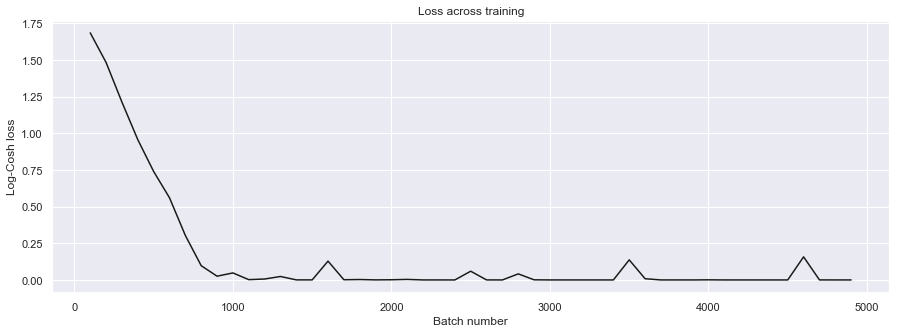

In [16]:
# plot loss curve (log cosh)
fig = plt.figure(figsize=(15, 5))

plt.plot(logged_batches, losses, color='k')
plt.title("Loss across training")
plt.xlabel('Batch number')
plt.ylabel('Log-Cosh loss');

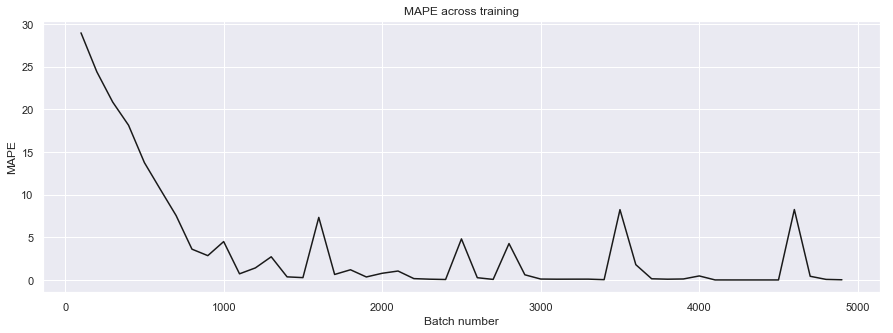

In [17]:
# plot MAPE curve
fig = plt.figure(figsize=(15, 5))

plt.plot(logged_batches, mapes, color='k')
plt.title("MAPE across training")
plt.xlabel('Batch number')
plt.ylabel('MAPE');

In [18]:
## take a look at the last batch to compare target vs output

last_batch = pd.DataFrame({
    'target': targets_tf.numpy(),
    'prediction': outputs_tf.numpy(),
    'n_nodes': inputs.n_node.numpy(),
    'n_edges': inputs.n_edge.numpy()
})

last_batch['error'] = last_batch['prediction'] - last_batch['target']
last_batch['%-error'] = last_batch['error'] / last_batch['target'] * 100

last_batch.head()

,target,prediction,n_nodes,n_edges,error,%-error
0,4.186666,4.186949,11,42,0.000283,0.006748
1,1.068788,1.068782,3,4,-0.000006,-0.000572
2,6.004132,6.003608,4,2,-0.000524,-0.008726
3,4.629095,4.628669,12,74,-0.000426,-0.009205
4,3.979239,3.979995,20,298,0.000756,0.018995


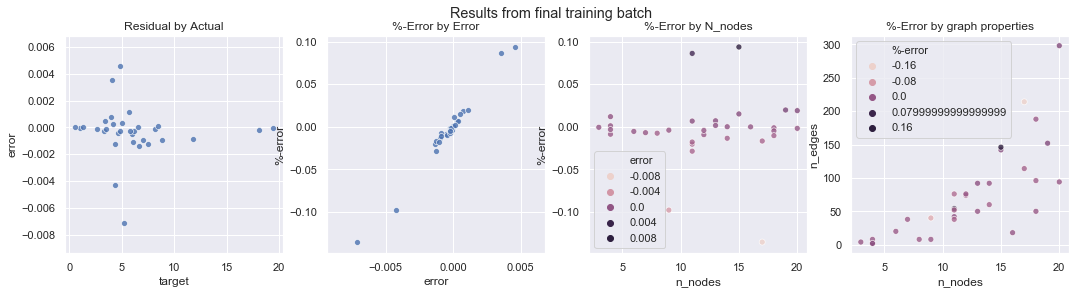

In [21]:
# visualize any relationships between error and graph properties

fig = plt.figure(11, figsize=(18, 4))
fig.suptitle('Results from final training batch')

ax = fig.add_subplot(1, 4, 1)
sns.scatterplot(data=last_batch, x='target', y='error', ax=ax, alpha=0.8)
ax.set_title('Residual by Actual')

ax = fig.add_subplot(1, 4, 2)
sns.scatterplot(data=last_batch, x='error', y='%-error', ax=ax, alpha=0.8)
ax.set_title('%-Error by Error')

ax = fig.add_subplot(1, 4, 3)
sns.scatterplot(data=last_batch, x='n_nodes', y='%-error', hue='error', ax=ax, alpha=0.8)
ax.set_title('%-Error by N_nodes')

ax = fig.add_subplot(1, 4, 4)
sns.scatterplot(data=last_batch, x='n_nodes', y='n_edges', hue='%-error', ax=ax, alpha=0.8)
ax.set_title('%-Error by graph properties');